In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import pandas as pd
Meta = pd.read_csv("../input/gtsrb-german-traffic-sign/Meta.csv")
Test = pd.read_csv("../input/gtsrb-german-traffic-sign/Test.csv")
Train = pd.read_csv("../input/gtsrb-german-traffic-sign/Train.csv")

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

def load_image(img_path):
    arr = img_to_array(load_img(img_path, target_size=(50, 50)))
    arr = np.expand_dims(arr, axis=0)
    arr = arr/255.0
    return arr

def load_images(img_paths):
    list_images = [load_image(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_images)

In [4]:
ROOT = '../input/gtsrb-german-traffic-sign/'

test_file_names = Test['Path'] 
train_file_names = Train['Path']

train_labels = Train['ClassId'].values
test_labels = Test['ClassId'].values

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

test_img_paths = ROOT + test_file_names
train_img_paths = ROOT + train_file_names

test_images = load_images(test_img_paths)
train_images = load_images(train_img_paths)

train_indices = np.arange(len(train_images))
np.random.shuffle(train_indices)

print(train_images.shape)
print(test_images.shape)

100%|██████████| 39209/39209 [01:31<00:00, 428.67it/s]


(39209, 50, 50, 3)
(12630, 50, 50, 3)


In [5]:
valid_size = int(0.2*len(train_images))
train_images, valid_images = train_images[train_indices[:-valid_size]], train_images[train_indices[-valid_size:]]
train_labels, valid_labels = train_labels[train_indices[:-valid_size]], train_labels[train_indices[-valid_size:]]
print("Number of train data - validation data : {} - {}".format(len(train_images), len(valid_images)))

Number of train data - validation data : 31368 - 7841


In [6]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
model = Sequential()

model.add(Conv2D(32, 3, activation='relu', input_shape=train_images.shape[1:]))
model.add(MaxPool2D(2))

model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPool2D(2))

model.add(Conv2D(128, 3, activation='relu'))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPool2D(2))

model.add(Conv2D(256, 3, activation='relu'))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(MaxPool2D(2))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(43, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 128)         1

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model.h5', save_best_model=True, monitor='val_loss',
                             verbose=0)
history = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
         epochs=10, verbose=1, callbacks=[checkpoint])

Train on 31368 samples, validate on 7841 samples
Epoch 1/10
31368/31368 [==============================] - 13s 412us/sample - loss: 2.1340 - accuracy: 0.3703 - val_loss: 0.6311 - val_accuracy: 0.7707
Epoch 2/10
31368/31368 [==============================] - 8s 263us/sample - loss: 0.3331 - accuracy: 0.8898 - val_loss: 0.1436 - val_accuracy: 0.9517
Epoch 3/10
31368/31368 [==============================] - 8s 267us/sample - loss: 0.1243 - accuracy: 0.9611 - val_loss: 0.0823 - val_accuracy: 0.9750
Epoch 4/10
31368/31368 [==============================] - 8s 270us/sample - loss: 0.0824 - accuracy: 0.9750 - val_loss: 0.0610 - val_accuracy: 0.9811
Epoch 5/10
31368/31368 [==============================] - 9s 275us/sample - loss: 0.0716 - accuracy: 0.9793 - val_loss: 0.0839 - val_accuracy: 0.9768
Epoch 6/10
31368/31368 [==============================] - 9s 271us/sample - loss: 0.0571 - accuracy: 0.9838 - val_loss: 0.1044 - val_accuracy: 0.9755
Epoch 7/10
31368/31368 [==========================

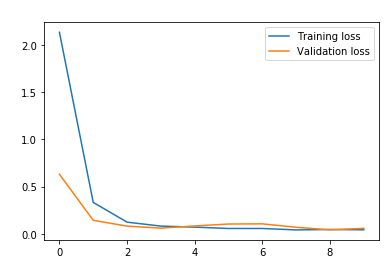

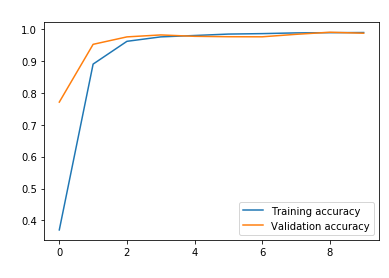

In [11]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss', color='white')
plt.xlabel('epoch', color='white')
plt.ylabel('loss', color='white')
plt.legend()

plt.figure(1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy', color='white')
plt.xlabel('epoch', color='white')
plt.ylabel('accuracy', color='white')
plt.legend()

In [12]:
from tensorflow.keras.models import load_model 

best_model = load_model('model.h5')
best_model.evaluate(test_images, test_labels)

12630/12630 [==============================] - 2s 151us/sample - loss: 0.2590 - accuracy: 0.9546


[0.2590458783112639, 0.9546318]